In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import display
import camb
from hdfisher import utils
from hd_mock_data import hd_data
from hd_pk import cmb_from_pk
%matplotlib inline
import matplotlib.colors
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 250

/home/amacinnis/.local/lib/python3.9/site-packages/hdfisher/mpi.py:50: UserWarning: Not using MPI
  warnings.warn('Not using MPI')


# CMB-HD Lensing SNR 

This notebook will reproduce the plot and table of CMB-HD lensing signal-to-noise ratio (SNR) values in MacInnis & Sehgal (2024).

## Choose whether to save the output of the notebook

If you would like to save the plots created below:
- change `save = False` to `save = True`
- (optional) change the `output_dir` to the absolute path of the directory where you want to save the output, e.g. `output_dir = '/path/to/output'`. By default, this is whatever directory you're running this notebook from.

If you set `save=True`, this will also save the wavenumbers and error bars on the matter power spectrum (Figure 2) for CMB-HD, which are calculated at the end of this notebook. 
- This is _not_ required; we provide everything needed to re-create Figure 2 in a separate notebook.

In [2]:
save = False
output_dir = os.getcwd()

In [3]:
if save:
    print('The output will be saved in the following directory:', output_dir)

## Choose whether to calculate theory spectra or load it from a file

Each theory calculation may take a few minutes, so we will read in the theory spectra from files by default. If you would like to do the calculation in the notebook instead, change `calculate_theory = False` to `calculate_theory = True` in the cell below:

In [4]:
calculate_theory = False

---

# Setup: set the multipole ranges and load the HD noise, covariance matrix, and binning

We will use the `hd_mock_data` package to make this easier.

In [5]:
datalib = hd_data.HDMockData(version='v1.1') # fix the version to ensure results are reproduced

We use the (lensed and unlensed) CMB $TT$, $TE$, $EE$, $BB$, and CMB lensing $\kappa\kappa$ power spectra, with $\ell_\mathrm{min} = 30$, $\ell_\mathrm{max} = 20,000$ for $TE$, $EE$, $BB$, $\kappa\kappa$, and $\ell_\mathrm{max}^{TT} = 40,000$ for $TT$.

In [6]:
# multipole ranges:
lmin = datalib.lmin
lmax = datalib.lmax
lmaxTT = datalib.lmaxTT
ells = np.arange(lmaxTT+1)

# list of spectra we use:
spectra = ['tt', 'te', 'ee', 'bb', 'kk']

Below we load in the noise curves for each spectrum. These are used to calculate diagonal covariance matrices below. 

We load in the pre-computed noise curves for each spectrum up to $\ell_\mathrm{max}^{TT} = 40,000$ into a dictionary, but set the $TE$, $EE$, $BB$, $\kappa\kappa$ noise to zero above $\ell_\mathrm{max} = 20,000$ (we will do the same for the power spectra). This is done to make sure we're only including data in the HD multipole range when calculating the signal-to-noise ratios (SNRs).

In [7]:
noise = datalib.cmb_noise_spectra() # CMB noise
_, nlkk = datalib.lensing_noise_spectrum() # lensing noise
# set other noise curves to zero after lmax for the SNR calculation:
noise['kk'] = np.zeros(noise['tt'].shape)
noise['kk'][:lmax+1] = nlkk
for s in ['te', 'ee', 'bb']:
    noise[s][lmax+1:] = 0

Now we load in the full $5 \times 5$ block covariance matrix for the lensed CMB and CMB lensing spectra, calculated up to $\ell_\mathrm{max}$, which includes the lensing-induced correlations between spectra (i.e., it contains off-diagonal elements). For $TT$ in the range $(20000,~40000)$, we also load in a pre-computed binned diagonal covariance matrix. We use these to calculate the signal-to-noise (SNR) ratio for CMB-HD lensing. 

In [8]:
covmat = datalib.block_covmat('lensed')
covmat_tt = datalib.tt_diag_covmat('lensed')

The covariance matrices are binned, so we load in the bin edges and the binning matrices used to bin them:

In [9]:
bin_edges = datalib.bin_edges()
# binning matrix for 30 < ell < 20,000:
bmat = datalib.binning_matrix(lmin=lmin, lmax=lmax)
# binning matrix for 20,000 < ell < 40,000:
bmatTT = datalib.binning_matrix(lmin=lmax, lmax=lmaxTT)

In the bottom panel of Figure 6, we use uniform $\Delta \ell = 30$ binning, which differs from the binning used in the covariance matrix. We define that binning below:

In [10]:
delta_ell = 30
uniform_bin_edges = np.arange(lmin, lmaxTT+1, delta_ell)
# number of bins for TT:
nbin_tt = len(uniform_bin_edges) - 1 
# number of bins for TE, EE, BB, kk:
loc = np.where(uniform_bin_edges <= lmax)
nbin = len(uniform_bin_edges[loc]) - 1
# get the binning matrix:
uniform_bmat = utils.binning_matrix(uniform_bin_edges, lmin=lmin, lmax=lmaxTT, start_at_ell=2)

---

# Calculating theory spectra

__Note__: If you set `calculate_theory = True` at the beginning of the notebook, each theory calculation may take a few minutes to run, depending on your machine.

We use the Limber approximation to calculate the CMB lensing power spectrum $C_L^{\kappa\kappa}$ by integrating over the (three-dimensional) power spectrum $P_\Psi(k,z)$ of the potential $\Psi$, $$C_L^{\kappa\kappa} = [L(L+1)]^2 \int_0^{\chi_*} d\chi~ \left(\frac{\chi_* - \chi}{\chi_* \chi^2}\right)^2 P_\Psi\left(\frac{L + \frac{1}{2}}{\chi},~z(\chi)\right),$$  where we have used the approximation $$k \approx \frac{\ell + 1/2}{\chi(z)}$$ to relate the wavenumber $k$ (units of inverse Mpc) and multipole $\ell$ at the redshift $z$, where $\chi(z)$ is the comoving distance (units of Mpc) to redshift $z$ and $\chi_* = \chi(z_*)$ is the comoving distance to the last scattering surface at $z_* \approx 1100$.

- We obtain $P_\Psi(k,z)$ from CAMB to calculate $C_L^{\kappa\kappa}$, and then pass $C_L^{\kappa\kappa}$ back to CAMB to get the lensed CMB power spectra $C_\ell^{XY}$ for $XY \in \{TT,TE,EE,BB\}$.
- We also obtain the unlensed CMB power spectra $\tilde{C}_\ell^{XY}$ for $XY \in \{TT,TE,EE,BB\}$ directly from CAMB.
- The calculation is done using the `calculate_theory_spectra` function in `cmb_from_pk.py`.

In [11]:
# directory where precomputed theory spectra are stored:
theo_dir = os.path.join(cmb_from_pk.hd_pk_dir(), 'lensing_plot_data')
theo_path = lambda x: os.path.join(theo_dir, x)

In [12]:
# load in a dictionary with our fiducial cosmology and accuracy settings that can be passed to CAMB:
camb_params_dict = cmb_from_pk.fid_params(only_camb=True) 
# initialize CAMB:
pars = camb.set_params(**camb_params_dict)
bg_results = camb.get_background(pars)
if calculate_theory:
    results = camb.get_results(pars)

## Lensing from all redshifts

In [13]:
if calculate_theory:
    theo_dicts = cmb_from_pk.calculate_theory_spectra(lmaxTT, pars, camb_results=results, cmb_types=['lensed', 'unlensed'])
    theo_lensed = theo_dicts['lensed']
    theo_unlensed = theo_dicts['unlensed']
    # set the unlensed C_L^kk = 0
    theo_unlensed['kk'] *= 0
    # set TE, EE, BB, and kk spectra to zero above lmax = 20,000:
    for s in ['te', 'ee', 'bb', 'kk']:
        theo_lensed[s][lmax+1:] = 0
        theo_unlensed[s][lmax+1:] = 0
else:
    theo_lensed = utils.load_from_file(theo_path('lensed_cls.txt'), datalib.theo_cols)
    theo_unlensed = utils.load_from_file(theo_path('unlensed_cls.txt'), datalib.theo_cols)

## Lensing from a range of redshifts

We want to know how sensitive CMB-HD is to lensing at a given redshift, so we consider redshifts $z \in [0,6]$, and break this range in to 12 bins of width $\Delta z = 0.5$.

In [14]:
zmax = 6
delta_z = 0.5
# get the bin edges and bin centers:
z_bin_edges = np.arange(0, zmax + delta_z, delta_z)
z_bin_ctrs = (z_bin_edges[1:] + z_bin_edges[:-1]) / 2
z_nbins = len(z_bin_ctrs)

Instead of integrating $C_L^{\kappa\kappa}$ from $\chi(z=0)$ to $\chi(z_*)$, now we only integrate over redshifts in each redshift bin, defining $$C_L^{\kappa\kappa,z_i} = [L(L+1)]^2 \int_{\chi_\mathrm{min}^{z_i}}^{\chi_\mathrm{max}^{z_i}} d\chi~ \left(\frac{\chi_* - \chi}{\chi_* \chi^2}\right)^2 P_\Psi\left(\frac{L + \frac{1}{2}}{\chi},~z(\chi)\right)$$ for the $i^\mathrm{th}$ bin, where $\chi_\mathrm{min}^{z_i} = \chi\left(z_{i,\mathrm{min}}\right)$ and $\chi_\mathrm{max}^{z_i} = \chi\left(z_{i,\mathrm{max}}\right)$ are evaluated at the bin edges $z_{i,\mathrm{min}}, z_{i,\mathrm{max}}$.

In [15]:
theo_lensed_per_zbin = {}
# loop over the redshift bins
for i in range(z_nbins):
    # integration limits:
    zmin_int = z_bin_edges[i]
    zmax_int = z_bin_edges[i+1]
    if calculate_theory:
        print(f'bin i = {i}: {zmin_int:3.1f} < z < {zmax_int:3.1f}')
        theo_lensed_per_zbin[i] = cmb_from_pk.calculate_theory_spectra(lmaxTT, pars, camb_results=results, cmb_types=['lensed'],
                                                                       zmin=zmin_int, zmax=zmax_int)['lensed']
        # set all but TT to zero above lmax:
        for s in ['te', 'ee', 'bb', 'kk']:
            theo_lensed_per_zbin[i][s][lmax+1:] = 0
    else:
        z_min = round(zmin_int, 1)
        z_max = round(zmax_int, 1)
        theo_lensed_per_zbin[i] = utils.load_from_file(theo_path(f'lensed_cls_zmin{z_min}_zmax{z_max}.txt'), datalib.theo_cols)

We will also calculate the theory by integrating over $z \in [0,6]$ and $z \in [6, 1100]$:

In [16]:
if calculate_theory:
    theo_lensed_zmax6 = cmb_from_pk.calculate_theory_spectra(lmaxTT, pars, camb_results=results, 
                                                             cmb_types=['lensed'],
                                                             zmin=0, zmax=6)['lensed']
    theo_lensed_zmin6 = cmb_from_pk.calculate_theory_spectra(lmaxTT, pars, camb_results=results, 
                                                             cmb_types=['lensed'],
                                                             zmin=6, zmax=1100)['lensed']
    # set all but TT to zero above lmax:
    for s in ['te', 'ee', 'bb', 'kk']:
        theo_lensed_zmax6[s][lmax+1:] = 0
        theo_lensed_zmin6[s][lmax+1:] = 0
else:
    theo_lensed_zmax6 = utils.load_from_file(theo_path(f'lensed_cls_zmax6.txt'), datalib.theo_cols)
    theo_lensed_zmin6 = utils.load_from_file(theo_path(f'lensed_cls_zmin6.txt'), datalib.theo_cols)

---

# Calculate diagonal covariance matrices for each redshift bin

We use the Knox formula to calculate the variance $\left(\sigma_\ell^{XY,z_i}\right)^2$ of the (lensed CMB or CMB lensing) power spectrum $C_\ell^{XY,z_i}$ for $XY \in \{TT, TE, EE, BB, \kappa\kappa\}$ in the $i^\mathrm{th}$ redshift bin: $$\left(\sigma_\ell^{XY,z_i}\right)^2 = \frac{1}{f_\mathrm{sky} (2\ell + 1)} \left[\left(C_\ell^{XX,z_i} + N_\ell^{XX}\right) \left(C_\ell^{YY,z_i} + N_\ell^{YY}\right) + \left(C_\ell^{XY,z_i} + N_\ell^{XY}\right)^2\right],$$ where $N_\ell^{XY}$ is the noise on $C_\ell^{XY}$ (it is the same for all redshifts).

In [17]:
fsky = 0.6

def get_knox_errors(theo, noise=noise, ells=ells, fsky=fsky):
    """
    Get the errors from the variance of the lensed spectra using the Knox formula.
    
    theo : dict holding the lensed spectra, with keys ['tt', 'te', 'ee', 'bb', 'kk']
    noise : dict holding the noise spectra, with keys ['tt', 'te', 'ee', 'bb', 'kk']
    ells : array of multipoles for the spectra
    fsky : the observed sky fraction
    
    returns a dict holding the error bar on each spectrum, 
    with keys for ['tt', 'te', 'ee', 'bb', 'kk']
    """
    const = 1 / (fsky * (2 * ells + 1))
    const[:2] = 0 
    errors = {}
    for s in ['tt', 'ee', 'bb', 'kk']:
        errors[s] = np.sqrt(2 * const * (theo[s] + noise[s])**2)
    errors['te'] =  np.sqrt(const * ( (theo['tt'] + noise['tt']) * (theo['ee'] + noise['ee']) + theo['te']**2))
    return errors

In [18]:
# calculate the set of Knox errors for each redshift bin:
errors_per_zbin = {}
for n in range(z_nbins):
    errors_per_zbin[n] = get_knox_errors(theo_lensed_per_zbin[n])
# calculate the set of Knox errors for the redshift range 6 <= z <= 1100:
errors_zmin6 = get_knox_errors(theo_lensed_zmin6)

---

# Calculate the lensing SNR

## Total lensing SNR over all multipoles and redshifts, using the full covariance matrix (Table 3)

First we need to bin the spectra, using the same binning as the covariance matrix: $C_{\ell_b}^{XY} = M_{b\ell} C_\ell^{XY}$ for each $XY \in \{TT, TE, EE, BB, \kappa\kappa\}$, where $\ell_b$ is the $b^\mathrm{th}$ bin center and $M$ is the $n_\mathrm{bin} \times n_\ell$ binning matrix.

In [19]:
def bin_theo(theo, bmat, lmax):
    """
    Bin a dictionary of power spectra.
    
    theo : dict holding the unbinned spectra, with keys ['tt', 'te', 'ee', 'bb', 'kk'] 
    bmat : the binning matrix
    lmax : the maximum multipole to use
    
    Returns a dictionary of the binned spectra, with the same keys as `theo`.
    """
    btheo = {}
    for s in theo.keys():
        btheo[s] = bmat @ theo[s][2:lmax+1]
    return btheo

In [20]:
# bin the lensed and unlensed spectra up to lmax = 20,000:
btheo_lensed = bin_theo(theo_lensed, bmat, lmax)
btheo_unlensed = bin_theo(theo_unlensed, bmat, lmax)

# bin the lensed and unlensed TT spectra for 20,000 < ell < 40,000:
binned_tt_lensed = bmatTT @ theo_lensed['tt'][2:]
binned_tt_unlensed = bmatTT @ theo_unlensed['tt'][2:]

For the $TT, TE, EE, BB, \kappa\kappa$ spectra in the range $\ell \in [30, 20000]$, we calculate the total lensing SNR as

$$\left.\left(\frac{S}{N}\right)\right|_{\ell\in[30,20000]} = \sqrt{ \sum_{b_1=1}^{5 n_\mathrm{bin}} \sum_{b_2=1}^{5 n_\mathrm{bin}} \left[C_{b_1} - \tilde{C}_{b_1}\right] \left(\mathbb{C}^{-1}\right)_{b_1 b_2}  \left[C_{b_2} - \tilde{C}_{b_2}\right]},$$ where:

- $n_\mathrm{bin}$ is the number of bins in the range $\ell \in [30, 20000]$: 
  - each spectrum has $n_\mathrm{bin}$ bins, and 
  - the blocks of the lensed covariance matrix $\mathbb{C}$ have shape $n_\mathrm{bin} \times n_\mathrm{bin}$
- $C_b$ is the $b^\mathrm{th}$ element of the vector of lensed spectra with length $5n_\mathrm{bin}$, defined as $$\mathbf{C} = \left(C_{1}^{TT},~\dots,~C_{n_\mathrm{bin}}^{TT}, C_{1}^{TE},~\dots,~C_{n_\mathrm{bin}}^{TE}, C_{1}^{EE},~\dots,~C_{n_\mathrm{bin}}^{EE}, C_{1}^{BB},~\dots,~C_{n_\mathrm{bin}}^{BB}, C_{1}^{\kappa\kappa},~\dots,~C_{n_\mathrm{bin}}^{\kappa\kappa} \right),$$ where the subscripts indicate the bin number.
  - $\tilde{C}_b$ is the $b^\mathrm{th}$ element of the corresponding vector of unlensed spectra.
- $\mathbb{C}^{-1}$ is the inverse of the full $5n_\mathrm{bin} \times 5n_\mathrm{bin}$ covariance matrix, which takes the form $$\mathbb{C} = \begin{pmatrix} \mathbb{C}^{TT,TT} & \mathbb{C}^{TT,TE} & \cdots & \mathbb{C}^{TT,\kappa\kappa} \\ \mathbb{C}^{TE, TT} & \mathbb{C}^{TE, TE} & \cdots & \mathbb{C}^{TE,\kappa\kappa} \\ \vdots & \vdots & \ddots & \vdots \\ \mathbb{C}^{\kappa\kappa,TT} & \mathbb{C}^{\kappa\kappa,TE} & \cdots & \mathbb{C}^{\kappa\kappa,\kappa\kappa} \end{pmatrix}.$$
  - each block $\mathbb{C}^{XY,WZ}$ has shape $n_\mathrm{bin} \times n_\mathrm{bin}$, and the order along the rows/columns is $TT$, $TE$, $EE$, $BB$, $\kappa\kappa$.
 
For $TT$ in the range $\ell \in [20000, 40000]$, we use a diagonal covariance matrix, $\mathbb{C}_{b_1 b_2,\mathrm{diag}}^{TT,TT} = \delta_{b_1 b_2} \left(\sigma_{b_1}^{TT}\right)^2$, where $\sigma_b$ is the error bar on the $b^\mathrm{th}$ bin, so $$\left.\left(\frac{S}{N}\right)^{TT}\right|_{\ell\in[20000,40000]} = \sqrt{\sum_{b=1}^{n_\mathrm{bin}^{TT}} \left[C_b^{TT} - \tilde{C}_b^{TT}\right]^2 / \left(\sigma_b^{TT}\right)^2},$$ where $n_\mathrm{bin}^{TT}$ is the number of bins in the range $\ell\in[20000,40000]$.

The total SNR is then found by summing these values in quadrature, $(S/N)^\mathrm{total} = \sqrt{(S/N)^2 + \left[(S/N)^{TT}\right]^2}$.

In [21]:
def calc_snr(x, y, cov):
    """
    Returns the SNR for the difference x - y, given a covariance matrix.
    """
    diff = x.copy() - y.copy()
    invcov = np.linalg.inv(cov.copy())
    tmp = invcov @ diff
    snr2 = diff.T @ tmp
    return np.sqrt(snr2)


def get_snr(btheo_lensed, btheo_unlensed, cov=covmat, 
            spectra=['tt', 'te', 'ee', 'bb', 'kk']):
    """
    Calculate the lensing SNR for a set of lensed and unlensed spectra.
    
    btheo_lensed : dictionary holding arrays of binned lensed spectra
    btheo_unlensed: dictionary holding arrays of binned unlensed spectra
    cov : the full block covariance matrix
    spectra : a list of spectra to use in the calculation, and the keys for the dictionary
    
    Returns the SNR value.
    """
    # vectors of binned lensed and unlensed spectra:
    lensed = np.hstack([btheo_lensed[s] for s in spectra])
    unlensed = np.hstack([btheo_unlensed[s] for s in spectra])
    # if we're not using all spectra in the covmat, only get the relevant blocks:
    if len(spectra) < 5:
        blocks = utils.cov_to_blocks(cov.copy())
        cov = utils.cov_from_blocks(blocks, spectra=spectra)
    # calculate and return the SNR:
    return calc_snr(lensed, unlensed, cov.copy())

In [22]:
# calculate the lensing SNR in the range 30 < ell < 20,000, for each individual spectrum and all of them:
print('Lensing SNR for 30 < ell < 20,000:')
snr_per_spectrum_from_cov = {}
for s in spectra:
    snr_per_spectrum_from_cov[s] = get_snr(btheo_lensed, btheo_unlensed, spectra=[s])
    print(f'{s}: {int(round(snr_per_spectrum_from_cov[s], 0))}')
snr_per_spectrum_from_cov['all'] = get_snr(btheo_lensed, btheo_unlensed)

# calculate the lensing SNR in the range 20,000 < ell < 40,000 for TT:
print('Lensing SNR for 20,000 < ell < 40,000:')
diff_tt = binned_tt_lensed - binned_tt_unlensed
invcov_tt = np.linalg.inv(covmat_tt)
snr_tt_from_cov = np.sqrt(diff_tt.T @ invcov_tt @ diff_tt)
print(f'tt: {int(round(snr_tt_from_cov, 0))}')

# get the total S/N from all spectra:
snr_total = np.sqrt(snr_per_spectrum_from_cov['all']**2 + snr_tt_from_cov**2)
print(f'Total lensing SNR from all spectra: {int(round(snr_total, 0))}')

Lensing SNR for 30 < ell < 20,000:
tt: 1571
te: 161
ee: 276
bb: 493
kk: 1287
Lensing SNR for 20,000 < ell < 40,000:
tt: 79
Total lensing SNR from all spectra: 1947


## Total lensing SNR over all multipoles in the redshift range $0 < z < 6$, using the full covariance matrix

We repeat the same calculation for the SNR as above, but now we use the $C_L^{\kappa\kappa}$ that was integrated over $0 \leq z \leq 6$, and the lensed CMB spectra that were lensed by this $C_L^{\kappa\kappa}$. 

Later, we will compare this SNR value to the SNR obtained when we approximate the covariance matrix as diagonal using the Knox formula, and summing the values of SNR per redshift bin in quadrature.

In [23]:
# bin the lensed and unlensed spectra up to lmax = 20,000:
btheo_lensed_zmax6 = bin_theo(theo_lensed_zmax6, bmat, lmax)

# bin the lensed and unlensed TT spectra for 20,000 < ell < 40,000:
binned_tt_lensed_zmax6 = bmatTT @ theo_lensed_zmax6['tt'][2:]

# calculate the lensing SNR in the range 30 < ell < 20,000; for each individual spectrum and all of them:
print('For 0 < z < 6:')
print('Lensing SNR for 30 < ell < 20,000:')
snr_per_spectrum_zmax6 = {}
for s in spectra:
    snr_per_spectrum_zmax6[s] = get_snr(btheo_lensed_zmax6, btheo_unlensed, spectra=[s])
    print(f'{s}: {int(round(snr_per_spectrum_zmax6[s], 0))}')
snr_per_spectrum_zmax6['all'] = get_snr(btheo_lensed_zmax6, btheo_unlensed)

# calculate the lensing SNR in the range 20,000 < ell < 40,000 for TT:
print('Lensing SNR for 20,000 < ell < 40,000:')
diff_tt_zmax6 = binned_tt_lensed_zmax6 - binned_tt_unlensed
invcov_tt = np.linalg.inv(covmat_tt)
snr_tt_zmax6 = np.sqrt(diff_tt_zmax6.T @ invcov_tt @ diff_tt_zmax6)
print(f'tt: {int(round(snr_tt_zmax6, 0))}')

# get the total SNR from all spectra:
snr_total_zmax6 = np.sqrt(snr_per_spectrum_zmax6['all']**2 + snr_tt_zmax6**2)
print(f'Total lensing SNR from all spectra: {int(round(snr_total_zmax6, 0))}')

For 0 < z < 6:
Lensing SNR for 30 < ell < 20,000:
tt: 1351
te: 133
ee: 221
bb: 386
kk: 1029
Lensing SNR for 20,000 < ell < 40,000:
tt: 75
Total lensing SNR from all spectra: 1632


## Lensing SNR per multipole and per redshift bin

For diagonal covariance matrices, the SNR for the difference between the lensed and unlensed spectrum in the $i^\mathrm{th}$ redshift bin, $C_\ell^{XY,z_i} - \tilde{C}_\ell^{XY}$ for $XY \in \{TT, TE, EE, BB, \kappa\kappa\}$, is $$\left(\frac{S}{N}\right)^{z_i} = \sqrt{\sum_\ell \sum_{XY} \frac{\left[C_\ell^{XY,z_i} - \tilde{C}_\ell^{XY}\right]^2}{\left(\sigma_\ell^{XY,z_i}\right)^2}}.$$ 

We define the lensing SNR per multipole in the $i^\mathrm{th}$ redshift bin as $$\left(\frac{S}{N}\right)_\ell^{z_i} = \sqrt{\sum_{XY} \frac{\left[C_\ell^{XY,z_i} - \tilde{C}_\ell^{XY}\right]^2}{\left(\sigma_\ell^{XY,z_i}\right)^2}},$$ so $$\left(\frac{S}{N}\right)^{z_i} = \sqrt{\sum_\ell \left[\left(\frac{S}{N}\right)_\ell^{z_i}\right]^2}.$$

In [24]:
# use a dict to hold the SNR per ell, with a key for each redshift bin:
snr_per_ell_zbin = {}
# also keep track of the total SNR per redshift bin, summed over all ell's:
snr_per_zbin = {}
# and keep track of the SNR per spectrum, summed over the z bins:
snr_per_spec_zbin = {}
snr_per_spec_from_z_bins = {}

# loop over the redshift bins:
for n in range(z_nbins):
    snr_per_ell_zbin[n] = {}
    snr_per_spec_zbin[n] = {}
    # calculate the SNR per ell for each spectrum in this redshift bin:
    snr_per_ell_spectrum = {}
    # and the SNR summed over all ell's for each spectrum in this redshift bin:
    snr_per_spectrum = {}
    for s in spectra:
        snr_per_ell_spectrum[s] = np.abs(theo_lensed_per_zbin[n][s] - theo_unlensed[s]) / errors_per_zbin[n][s]
        snr_per_ell_spectrum[s][:2] = 0 # set to zero for ell = 0, 1
        # we need to set this to zero above lmax for all but TT:
        if s in ['te', 'ee', 'bb', 'kk']:
            snr_per_ell_spectrum[s][lmax+1:] = 0
            snr_per_spectrum[s] = np.sqrt(np.sum(snr_per_ell_spectrum[s][lmin:lmax+1]**2))
        else:
            snr_per_spectrum[s] = np.sqrt(np.sum(snr_per_ell_spectrum[s][lmin:lmaxTT+1]**2))
        snr_per_spec_zbin[n][s] = snr_per_spectrum[s].copy()
    # at each ell, sum over all spectra:
    snr_per_ell_zbin[n] = np.sqrt(np.sum([snr_per_ell_spectrum[s]**2 for s in spectra], axis=0))
    snr_per_zbin[n] = np.sqrt(np.sum([snr_per_spectrum[s]**2 for s in spectra], axis=0)) 
    
#  total SNR over all ell's and up to z = 6:
snr_from_z_bins = np.sqrt(np.sum([snr_per_zbin[n]**2 for n in range(z_nbins)]))
for s in spectra:
    snr_per_spec_from_z_bins[s] = np.sqrt(np.sum([snr_per_spec_zbin[n][s]**2 for n in range(z_nbins)]))

/tmp/ipykernel_94500/1903177910.py:18: RuntimeWarning: invalid value encountered in divide
  snr_per_ell_spectrum[s] = np.abs(theo_lensed_per_zbin[n][s] - theo_unlensed[s]) / errors_per_zbin[n][s]


We also calculate the $(S/N)_\ell$ for the range $z \in [6,1100]$:

In [25]:
# calculate the SNR per ell for each spectrum in this redshift range:
snr_per_ell_spectrum_zmin6 = {}
# and the SNR summed over all ell's for each spectrum in this redshift bin:
snr_per_spectrum_zmin6 = {}
# and keep track of the SNR per spectrum:
snr_per_spec_from_all_z = {}

for s in spectra:
    snr_per_ell_spectrum_zmin6[s] = np.abs(theo_lensed_zmin6[s] - theo_unlensed[s]) / errors_zmin6[s]
    snr_per_ell_spectrum_zmin6[s][:2] = 0 # set to zero for ell = 0, 1
    # we need to set this to zero above lmax for all but TT:
    if s in ['te', 'ee', 'bb', 'kk']:
        snr_per_ell_spectrum_zmin6[s][lmax+1:] = 0
        snr_per_spectrum_zmin6[s] = np.sqrt(np.sum(snr_per_ell_spectrum_zmin6[s][lmin:lmax+1]**2))
    else:
        snr_per_spectrum_zmin6[s] = np.sqrt(np.sum(snr_per_ell_spectrum_zmin6[s][lmin:lmaxTT+1]**2))
# sum over all spectra:
snr_zmin6 = np.sqrt(np.sum([snr_per_spectrum_zmin6[s]**2 for s in spectra], axis=0)) 

#  total SNR over all ell's and up to z = 6:
snr_from_all_z = np.sqrt(snr_from_z_bins**2 + snr_zmin6**2)
for s in spectra:
    snr_per_spec_from_all_z[s] = np.sqrt(snr_per_spec_from_z_bins[s]**2 + snr_per_spectrum_zmin6[s]**2)

/tmp/ipykernel_94500/4018457805.py:9: RuntimeWarning: invalid value encountered in divide
  snr_per_ell_spectrum_zmin6[s] = np.abs(theo_lensed_zmin6[s] - theo_unlensed[s]) / errors_zmin6[s]


In the bottom panel of Figure 6, we plot the SNR per $\Delta\ell = 30$ bin and per redshift bin, replacing the unbinned spectra and variance with their binned versions.

To bin the variance, we need to bin the diagonal covariance matrix, $\mathbb{C}_{\ell\ell'}^{XY,z_i} = \delta_{\ell\ell'} \left(\sigma_\ell^{XY,z_i}\right)^2$. The binned variances are the diagonal elements of the binned covariance matrix.

In [26]:
# bin the multipoles:
lbin = uniform_bmat @ ells[2:]

# bin the unlensed spectra:
binned_unlensed = bin_theo(theo_unlensed, uniform_bmat, lmaxTT)

# bin the lensed spectra per redshift bin:
binned_lensed_per_zbin = {}
for n in range(z_nbins):
    binned_lensed_per_zbin[n] = bin_theo(theo_lensed_per_zbin[n], uniform_bmat, lmaxTT)
    
# get the binned errors from the binned covariance matrix; this is the same as the binned variance, divided by delta_ell:
binned_errors_per_zbin = {}
for n in range(z_nbins):
    binned_errors_per_zbin[n] = {}
    for s in spectra:
        binned_variance = uniform_bmat @ (errors_per_zbin[n][s][2:]**2)
        binned_errors_per_zbin[n][s] = np.sqrt(binned_variance / delta_ell)

In [27]:
# use a dict to hold the SNR per ell bin, with a key for each redshift bin:
snr_per_lbin_zbin = {}
snr_per_lbin_zbin_spec = {}

# loop over the redshift bins:
for n in range(z_nbins):
    snr_per_lbin_zbin[n] = {}
    snr_per_lbin_zbin_spec[n] = {}
    # calculate the SNR per ell for each spectrum in this redshift bin:
    snr_per_spectrum = {}
    for s in spectra:
        snr_per_lbin_zbin_spec[n][s] = np.abs(binned_lensed_per_zbin[n][s] - binned_unlensed[s]) / binned_errors_per_zbin[n][s]
        # we need to set this to zero above lmax for all but TT:
        if s in ['te', 'ee', 'bb', 'kk']:
            snr_per_lbin_zbin_spec[n][s][nbin:] = 0
    # at each ell, sum over all spectra:
    snr_per_lbin_zbin[n] = np.sqrt(np.sum([snr_per_lbin_zbin_spec[n][s]**2 for s in spectra], axis=0))

/tmp/ipykernel_94500/3958704085.py:12: RuntimeWarning: invalid value encountered in divide
  snr_per_lbin_zbin_spec[n][s] = np.abs(binned_lensed_per_zbin[n][s] - binned_unlensed[s]) / binned_errors_per_zbin[n][s]


## Compare the total lensing SNR for $z \in [0,1100]$ or $z \in [0, 6]$  (Table 6)

We compare the total lensing SNR for $z \in [0,z_*]$ or $z \in [0,6]$ from all spectra and all multipoles calculated in two ways:

1. The "correct" way: the single SNR value obtained from integrating $C_L^{\kappa\kappa}$ over the $z$-range, getting the corresponding lensed CMB spectra, and using the full lensed covariance matrix (including off-diagonal elements), and
2. The "approximate" way: summing in quadrature over the SNR values obtained by integrating $C_L^{\kappa\kappa}$ in each redshift bin, getting the corresponding lensed CMB spectra, and then using a diagonal covariance matrix that was calculated from that set of spectra.

In [28]:
# put the values into dictionaries and round them before printing them out:
snr_full = {}
snr_approx = {}
snr_full_zmax6 = {}
snr_approx_zmax6 = {}
for s in spectra:
    if s == 'tt': # include all multipoles for TT:
        full_snr = np.sqrt(snr_per_spectrum_from_cov[s]**2 + snr_tt_from_cov**2)
        full_snr_zmax6 = np.sqrt(snr_per_spectrum_zmax6[s]**2 + snr_tt_zmax6**2)
    else:
        full_snr = snr_per_spectrum_from_cov[s]
        full_snr_zmax6 = snr_per_spectrum_zmax6[s]
    snr_full[s] = int(round(full_snr, 0))
    snr_approx[s] = int(round(snr_per_spec_from_all_z[s], 0))
    snr_full_zmax6[s] = int(round(full_snr_zmax6, 0))
    snr_approx_zmax6[s] = int(round(snr_per_spec_from_z_bins[s], 0))
# get the total SNR from all spectra:
snr_full['all'] = int(round(snr_total, 0))
snr_approx['all'] = int(round(snr_from_all_z, 0))
snr_full_zmax6['all'] = int(round(snr_total_zmax6, 0))
snr_approx_zmax6['all'] = int(round(snr_from_z_bins, 0))

# print out a table of SNR values:
table = pd.DataFrame([snr_full, snr_approx, snr_full_zmax6, snr_approx_zmax6], 
                     index=['correct, zmax=1100', 'approx, zmax=1100', 'correct, zmax=6', 'approx, zmax=6'], 
                     columns=spectra+['all'])
table = table.T
table_styles_dict = {'selector': 'caption', 'props': [('color', 'k'),('font-size', '26px')]}
table.style.set_caption('').set_table_styles([table_styles_dict])
display(table)

,"correct, zmax=1100","approx, zmax=1100","correct, zmax=6","approx, zmax=6"
tt,1573,850,1353,770
te,161,103,133,90
ee,276,149,221,126
bb,493,1044,386,906
kk,1287,1178,1029,1037
all,1947,1798,1632,1585


---

# Lensing SNR plot: bottom panel of Figure 6

__Note__: the following cell is optional, and may take a few minutes to run. You may skip it and just load in the necessary data by running the cell after it, under the text *"Or, load the wavenumbers corresponding to the non-linear regime at each redshift"*
- If you set `calculate_theory = False` at the beginning of the notebook, this cell will be skipped automatically.

In Figure 6, we plot a line $k_\mathrm{non-lin}(z)$ to indicate linear vs. non-linear scales. We define this as the wavenumber at a given redshift where the linear matter power spectrum $P_\mathrm{lin}(k,z)$ is suppressed by 1% relative to the non-linear matter power spectrum $P_\mathrm{non-lin}(k,z)$. We calculate $k_\mathrm{non-lin}(z)$ below:

In [29]:
if calculate_theory:
    # values used for this calculation:
    PK_kmax = 1000
    PK_zmax = 25
    PK_nonlin = camb.get_matter_power_interpolator(pars, nonlinear=True, 
            hubble_units=False, k_hunit=False, kmax=PK_kmax, zmax=PK_zmax)
    PK_lin = camb.get_matter_power_interpolator(pars, nonlinear=False, 
            hubble_units=False, k_hunit=False, kmax=PK_kmax, zmax=PK_zmax)
    
    # evaluate ratio of P(k)'s at many k's, and find the k where the ratio is less than 0.99:
    PK_ks = np.linspace(0.05, 0.25, 10000) 
    
    z_nonlin = np.arange(0, 6.26, 0.01) # do calculation for many redshifts
    k_nonlin = [] # holds the non-linear k at each z
    
    for z in z_nonlin:
        pk_ratio = PK_lin.P(z, PK_ks, grid=False)/PK_nonlin.P(z, PK_ks, grid=False)
        loc = np.where(pk_ratio < 0.99)
        k_nonlin.append(PK_ks[loc][0])
    k_nonlin = np.array(k_nonlin)

Or, load the wavenumbers corresponding to the non-linear regime at each redshift:

In [30]:
# load in the data giving the non-linear wavenumber [Mpc^-1] at each redshift:
k_nonlin, z_nonlin = np.loadtxt(theo_path('k_nonlin_vs_z.txt'), unpack=True)

We also plot a few curves for $\ell$ as a function of $k$ and $z$, which we calculate below:

In [31]:
# get the curves for specific ell's at a given k and z
ell_vals = [10, 30, 100, 1000, 5000, 20000, 40000]
zmin = 1e-7
nz = 10000
zs = np.linspace(zmin, zmax, nz) 
chis = bg_results.comoving_radial_distance(zs)
ells_per_k_z = {ell: np.divide(ell + 0.5, chis.copy()) for ell in ell_vals}

/tmp/ipykernel_94500/296966516.py:7: RuntimeWarning: divide by zero encountered in divide
  ells_per_k_z = {ell: np.divide(ell + 0.5, chis.copy()) for ell in ell_vals}


Now we can make the plot:

In [32]:
# setup for the figure:
figsize = (8, 6)
num_plt = z_nbins # number of subplots
# we add some space after the last subplot, so the y-axis begins at z = 0:
height_ratios = np.ones(num_plt+1)
height_ratios[-1] = 0.5
height_ratios /= np.sum(height_ratios)

# setup for the axis ticks:
ticksize = 14
# limits for x axis:
h = 0.67
xmin = 1e-3 / h
xmax = 70
# ticks for x axis:
kticks = [1e-2, 1e-1, 1, 10, 60]
ktick_labels = ['0.01', '0.1', '1', '10', '60']

# setup for the colorbar:
max_snr = 95 # maximum SNR value being plotted
colors = plt.cm.jet(np.linspace(0, 1, max_snr))
cmap = 'jet'

# font settings for text on the plot:
nonlin_font = {'family': 'serif', 'color': 'purple', 'weight': 'normal', 'size': 13}
ells_font = {'family': 'serif', 'color':  'black', 'weight': 'normal',  'size': 12}

# each subplot in the bottom panel of figure 6 corresponds to a redshift bin.
# for each subplot, we plot the curves that indicate ell or k_nonlin at each redshift within that bin.
# here we get the indices where those curves start and stop for each subplot:
zindex = []
zindex_nonlin = []
for i, zmin_bin in enumerate(z_bin_edges):
    zindex.append(np.argmin(np.abs(zs - 0.25 - (i/2))))
    zindex_nonlin.append(np.argmin(np.abs(z_nonlin - 0.25 - (i/2))))

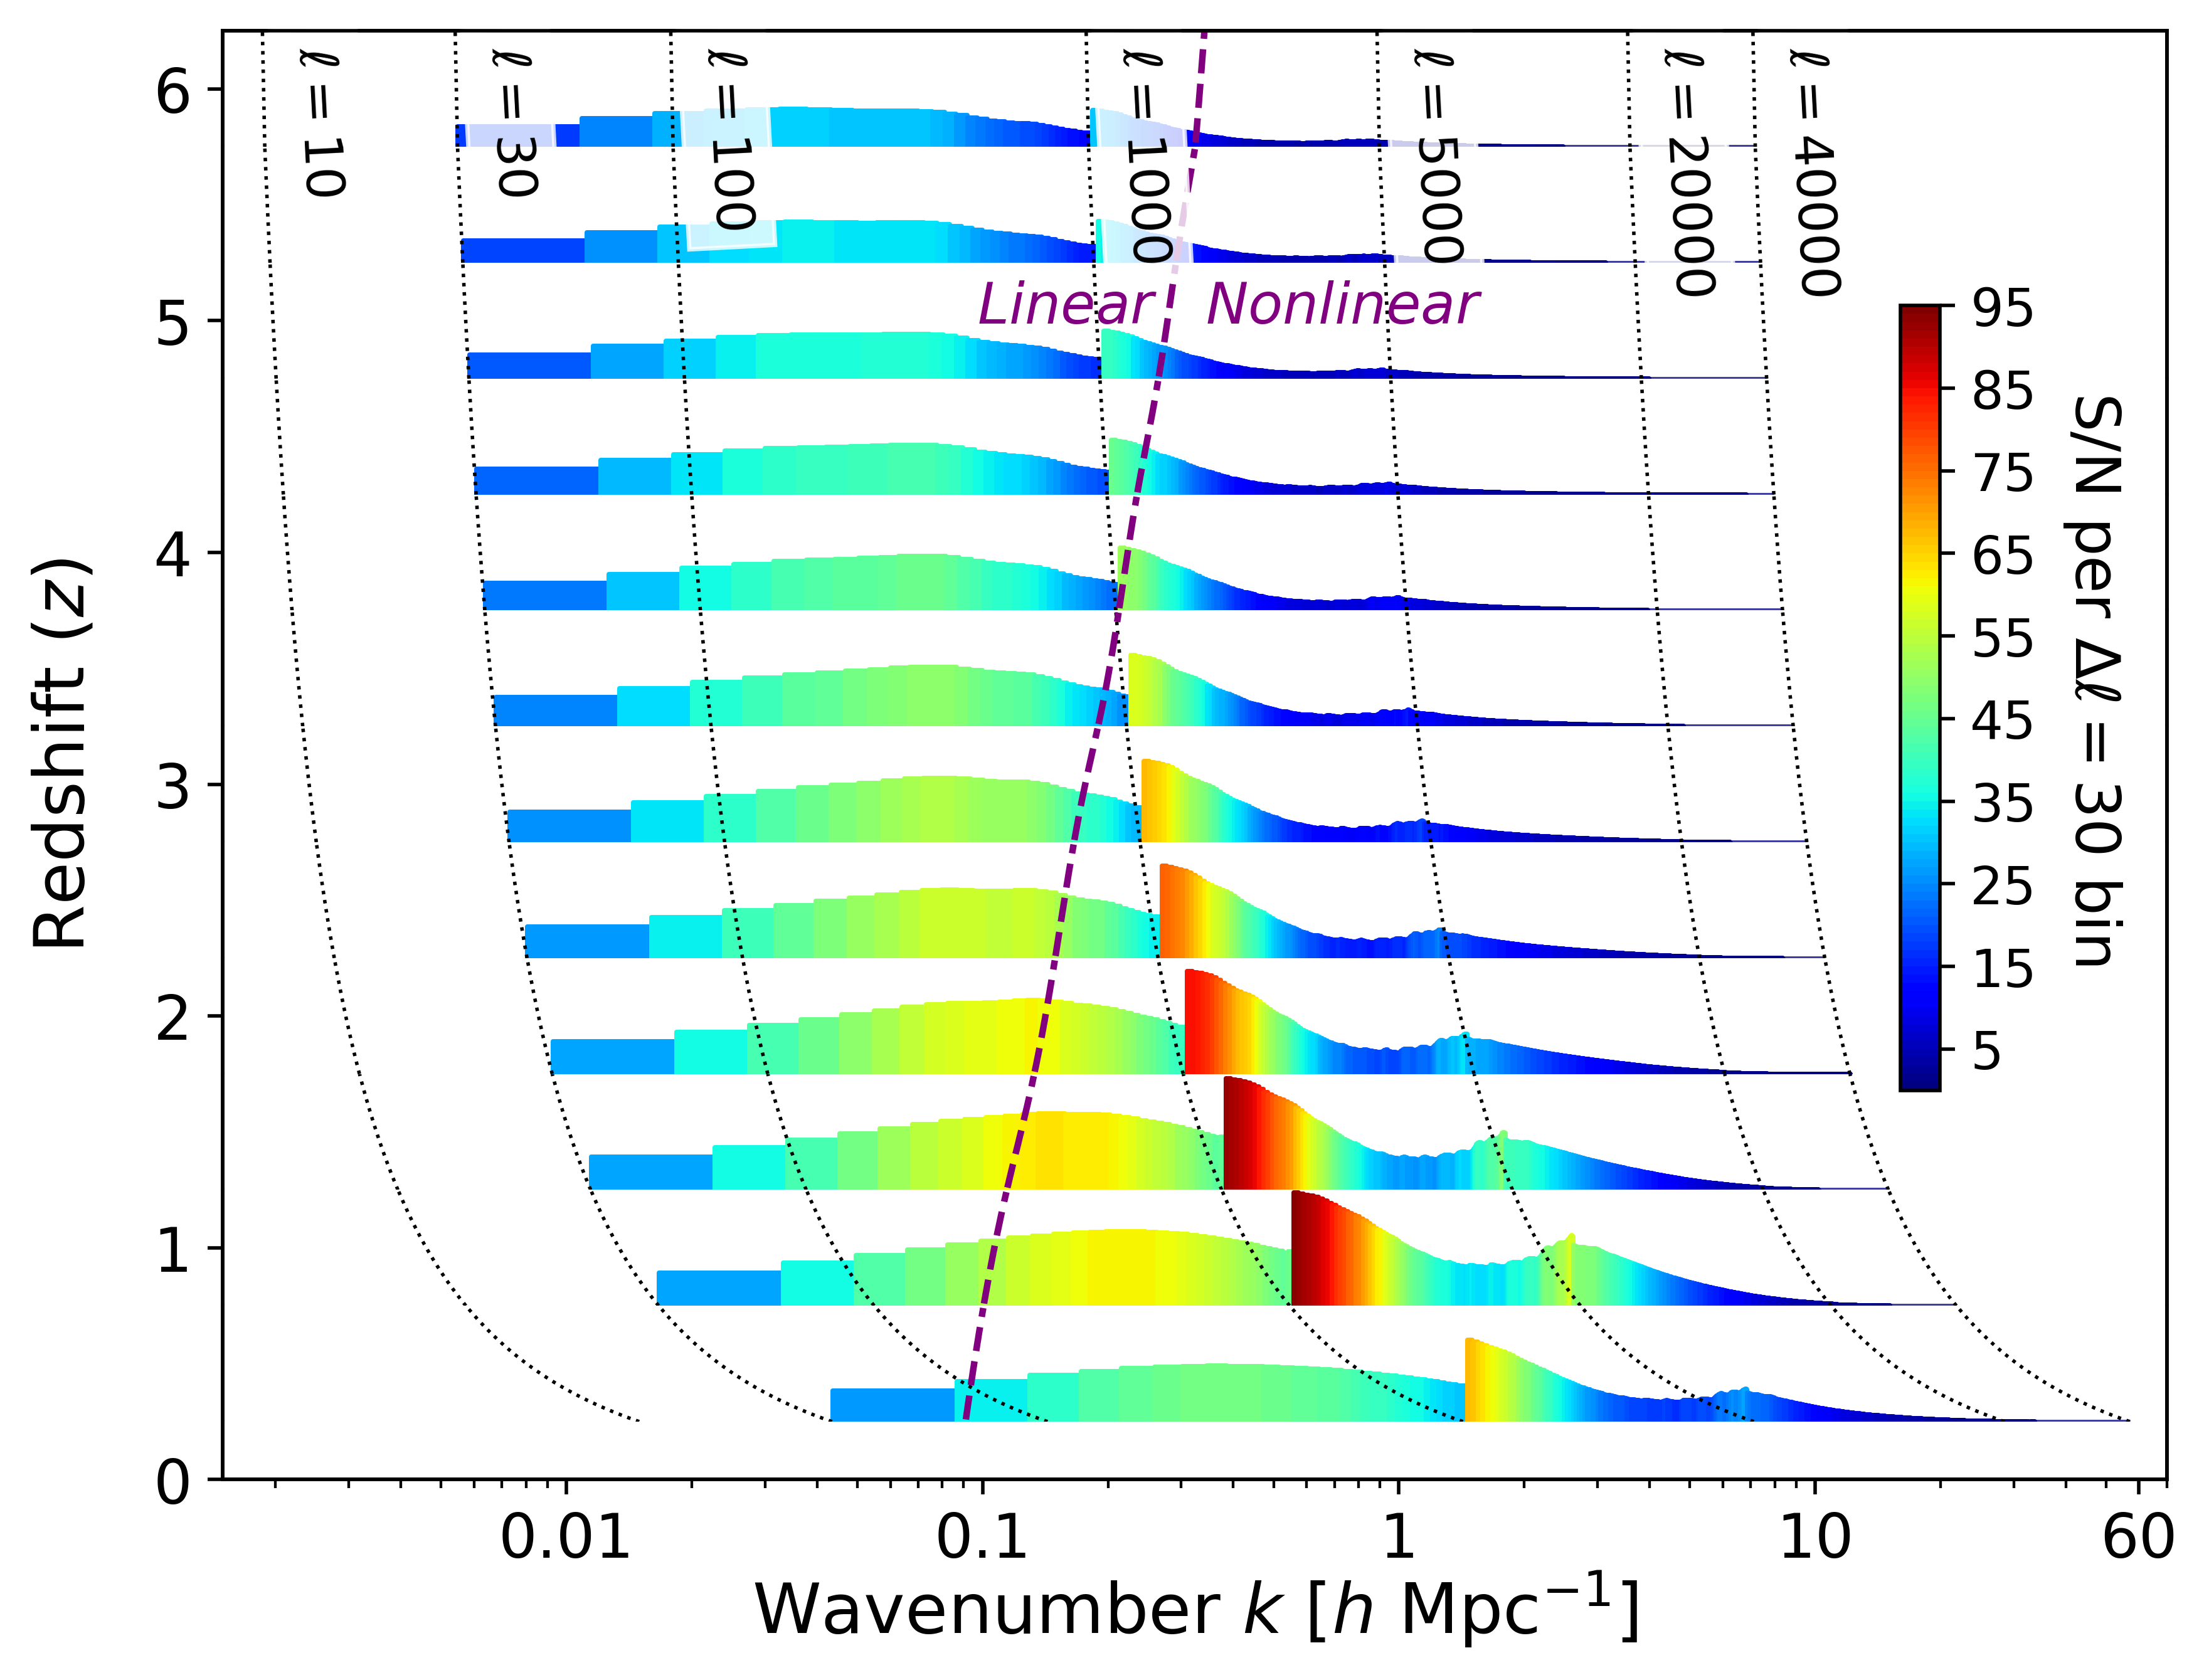

In [33]:
# make the plot:
fig, axs = plt.subplots(nrows=num_plt+1, ncols=1, 
                        gridspec_kw={'height_ratios': height_ratios},
                        figsize=figsize, dpi=500)

# there's nothing to plot for the last subplot, 
# but we can use it to label the x-axis and label z = 0 on the y-axis:
axs[-1].spines['top'].set_visible(False)
axs[-1].set_yticks([0])
axs[-1].set_yticklabels([0], fontsize=ticksize)
axs[-1].set_xlim([xmin, xmax])
axs[-1].xaxis.set_major_formatter(mticker.ScalarFormatter())
axs[-1].xaxis.get_major_formatter().set_scientific(False)
axs[-1].set_xscale('log')
axs[-1].set_xticks(kticks, labels=ktick_labels, fontsize=ticksize)

# loop through the redshift bins to make the subplots:
for i in range(num_plt):
    idx = num_plt - 1 - i # index for the subplot axis (first bin = bottom subplot)
    # set the same axis limits for each subplot:
    axs[idx].set_xscale('log')
    axs[idx].set_xlim([xmin, xmax])
    axs[idx].set_ylim([0, max_snr])
    # loop through the SNR values for each ell-bin, calculate the corresponding wavenumbers, 
    # and plot a bar for that wavenumber bin with the height and color indicating the SNR value:
    for j, snr in enumerate(snr_per_lbin_zbin[i]):
        # use get the wavenumbers corresponding to upper and lower ell-bin edge, using the redshift bin center:
        k_lower = (uniform_bin_edges[j] + 0.5)/bg_results.comoving_radial_distance(z_bin_ctrs[i])
        k_upper = (uniform_bin_edges[j+1] + 0.5)/bg_results.comoving_radial_distance(z_bin_ctrs[i])
        color = colors[round(snr)]
        axs[idx].fill_between([k_lower/h, k_upper/h], snr, color=color)
    # label the integer redshifts on the y-axis:
    if z_bin_edges[i+1]%1 == 0:
        axs[idx].set_yticks([max_snr/2])
        axs[idx].set_yticklabels([int(z_bin_edges[i+1])], fontsize=ticksize)
    else:
        axs[idx].set_yticks([])
    # set other axes, ticks, and labels to be invisible:
    axs[idx].set_xticks([])
    axs[idx].get_xaxis().set_visible(False)
    axs[idx].spines['bottom'].set_visible(False)
    if idx > 0:
        axs[idx].spines['top'].set_visible(False)
    
    # create a second axis on top of this one:
    ax2 = axs[idx].twinx()
    # plot the curves for the ell's vs. k for this range of z's:
    imin = zindex[i] + 1
    imax = zindex[i+1] 
    for ell in ell_vals:
        ax2.plot(ells_per_k_z[ell][imin:imax] / h, zs[imin:imax], color='k', ls=':', lw=0.8)
    # plot the non-linear wavenumbers for this range of redshifts:
    imin_nl = zindex_nonlin[i] + 1
    imax_nl = zindex_nonlin[i+1] 
    ax2.plot(k_nonlin[imin_nl:imax_nl] / h, z_nonlin[imin_nl:imax_nl], ls='--', color='purple')
    # set the axis limits and make them invisible
    ax2.set_xscale('log')
    ax2.set_xlim([xmin, xmax])
    ax2.set_ylim([zs[imin], zs[imax]])
    ax2.axis('off')
    
# label the ells
alpha = 0.8 
ells_xpos_fact = 1.15
ells_ypos = 5.97
for ell in ell_vals: 
    plt.text(ells_xpos_fact * np.min(ells_per_k_z[ell]/h), ells_ypos, r'$\ell = %d$' % ell, 
             fontdict=ells_font, backgroundcolor=(1,1,1,alpha), rotation=273, va='top')
    
# label the linear/non-linear wavenumber line
nonlin_ypos = 5.37
plt.text(0.065 / h, nonlin_ypos, r'$Linear$', fontdict=nonlin_font)
plt.text(0.23 / h, nonlin_ypos, r'$Nonlinear$', fontdict=nonlin_font)


# axis labels for the figure
fig_ax = fig.add_subplot(111, sharex=axs[0])
fig_ax.set_facecolor("none")
fig_ax.set_yticks([])
fig_ax.set_xticks([])
fig_ax.set_xlabel(r'Wavenumber $k$ [$h~$Mpc$^{-1}$]', fontsize=16, labelpad=15)
fig_ax.set_ylabel(r'Redshift ($z$)', fontsize=16, labelpad=25)

# make the colorbar:
cbar_ax = fig.add_subplot(6, 1, (1,5))
cmap = plt.get_cmap(cmap, max_snr)
cmaprev=cmap.reversed()
norm = matplotlib.colors.BoundaryNorm(np.arange(max_snr+1), max_snr)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ticks = list(range(5, max_snr+1, 10))
cbar = fig.colorbar(sm, ax=cbar_ax, ticks=cbar_ticks, 
                    shrink=0.65, 
                    anchor=(0.1, 0.35),
                    location='right')
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
for spine in ['top', 'bottom', 'left', 'right']:
    cbar_ax.spines[spine].set_visible(False)
cbar_ax.set_facecolor('none')
cbar.ax.tick_params(labelsize=12) 
cbar.ax.minorticks_off()
cbar.set_label(r'S/N per $\Delta \ell = %d$ bin$\quad$' % delta_ell, 
               rotation=270, fontsize=ticksize, y=0.525, labelpad=20)

    
plt.subplots_adjust(hspace=0)
if save:
    plt.savefig(os.path.join(output_dir, 'fig06_bottom.png'), dpi=250, bbox_inches='tight')
plt.show()

---

# Lensing SNR plot: top panel of Figure 6

In the top panel of Figure 6, we plot a histogram of the lensing SNR in 11 wavenumber bins, and for each, we break it down into the fraction of SNR from each redshift bin.

Below we define the wavenumber bins:

In [34]:
kmin = (lmin + 0.5)/bg_results.comoving_radial_distance(z_bin_ctrs[-1])
kmax = (lmaxTT + 0.5)/bg_results.comoving_radial_distance(z_bin_ctrs[0])
# we use evenly-spaced bins in log(k):
log_kmin = np.log10(kmin) 
log_kmax = np.log10(kmax)

k_nbins = 11
k_bin_edges = 10**np.linspace(log_kmin, log_kmax, k_nbins+1)
k_bin_ctrs = (k_bin_edges[1:] + k_bin_edges[:-1]) / 2

Above we defined the lensing SNR per multipole in the $i^\mathrm{th}$ redshift bin,  $$\left(\frac{S}{N}\right)_\ell^{z_i} = \sqrt{\sum_{XY} \frac{\left[C_\ell^{XY,z_i} - \tilde{C}_\ell^{XY}\right]^2}{\left(\sigma_\ell^{XY,z_i}\right)^2}},$$ so the total SNR in each _redshift_ bin $i$ is $$\left(\frac{S}{N}\right)^{z_i} = \sqrt{\sum_\ell \left[\left(\frac{S}{N}\right)_\ell^{z_i}\right]^2}.$$

We estimate the lensing SNR per redshift bin $i$ centered at redshift $z_i$, and wavenumber bin $j$ that contains wavenumbers from $k_j^\mathrm{min}$ to $k_j^\mathrm{max}$, as $$\left(\frac{S}{N}\right)^{z_i}_{k_j} = \sqrt{\sum_{\ell=\ell_\mathrm{min}(k_j,z_i)}^{\ell_\mathrm{max}(k_j,z_i)} \left[\left(\frac{S}{N}\right)_\ell^{z_i}\right]^2},$$ where the sum is taken from $\ell_\mathrm{min}(k_j,z_i) = k_j^\mathrm{min} \chi(z_i) - 1/2$ to $\ell_\mathrm{max}(k_j,z_i) = k_j^\mathrm{max} \chi(z_i) - 1/2$.

We estimate the total SNR in the $j^\mathrm{th}$ _wavenumber_ bin as $$\left(\frac{S}{N}\right)_{k_j}  = \sqrt{\sum_i \left[\left(\frac{S}{N}\right)^{z_i}_{k_j}\right]^2}.$$

In [35]:
# first loop through the wavenumber bins to find the total lensing SNR in each,
# also keeping track of the SNR from each wavenumber and redshift bin.
# then, for each wavenumber bin, calculate how much each redshift bin contributes to the SNR.

snr_per_kbin = {} # per k
snr_per_kbin_zbin = {} # per k and z
snr_per_kbin_zbin_frac = {} # contribution of each z to S/N at k

for j in range(k_nbins):
    kmin_bin = k_bin_edges[j]
    kmax_bin = k_bin_edges[j+1]
    snr_per_kbin_zbin[j] = {}
    for i, z in enumerate(z_bin_ctrs):
        # find minimum and maximum multipoles within this redshift and wavenumber bin:
        lmin_bin = round(kmin_bin * bg_results.comoving_radial_distance(z) - 0.5)
        lmax_bin = round(kmax_bin * bg_results.comoving_radial_distance(z) - 0.5)
        loc = np.where((ells[lmin:lmaxTT+1] >= lmin_bin) & (ells[lmin:lmaxTT+1] <= lmax_bin))[0]
        # sum over them:
        snr_per_kbin_zbin[j][i] = np.sqrt(np.sum(snr_per_ell_zbin[i][loc]**2))
    # sum over the redshift bins to get the total:
    snr_per_kbin[j] = np.sqrt(np.sum([snr_per_kbin_zbin[j][i]**2 for i in range(z_nbins)]))
    # look at how much each redshift bin contributes:
    snr_per_kbin_zbin_frac[j] = {}
    for i, z in enumerate(z_bin_ctrs):
        snr_per_kbin_zbin_frac[j][i] = snr_per_kbin_zbin[j][i]**2 / snr_per_kbin[j]**2

Make the plot:

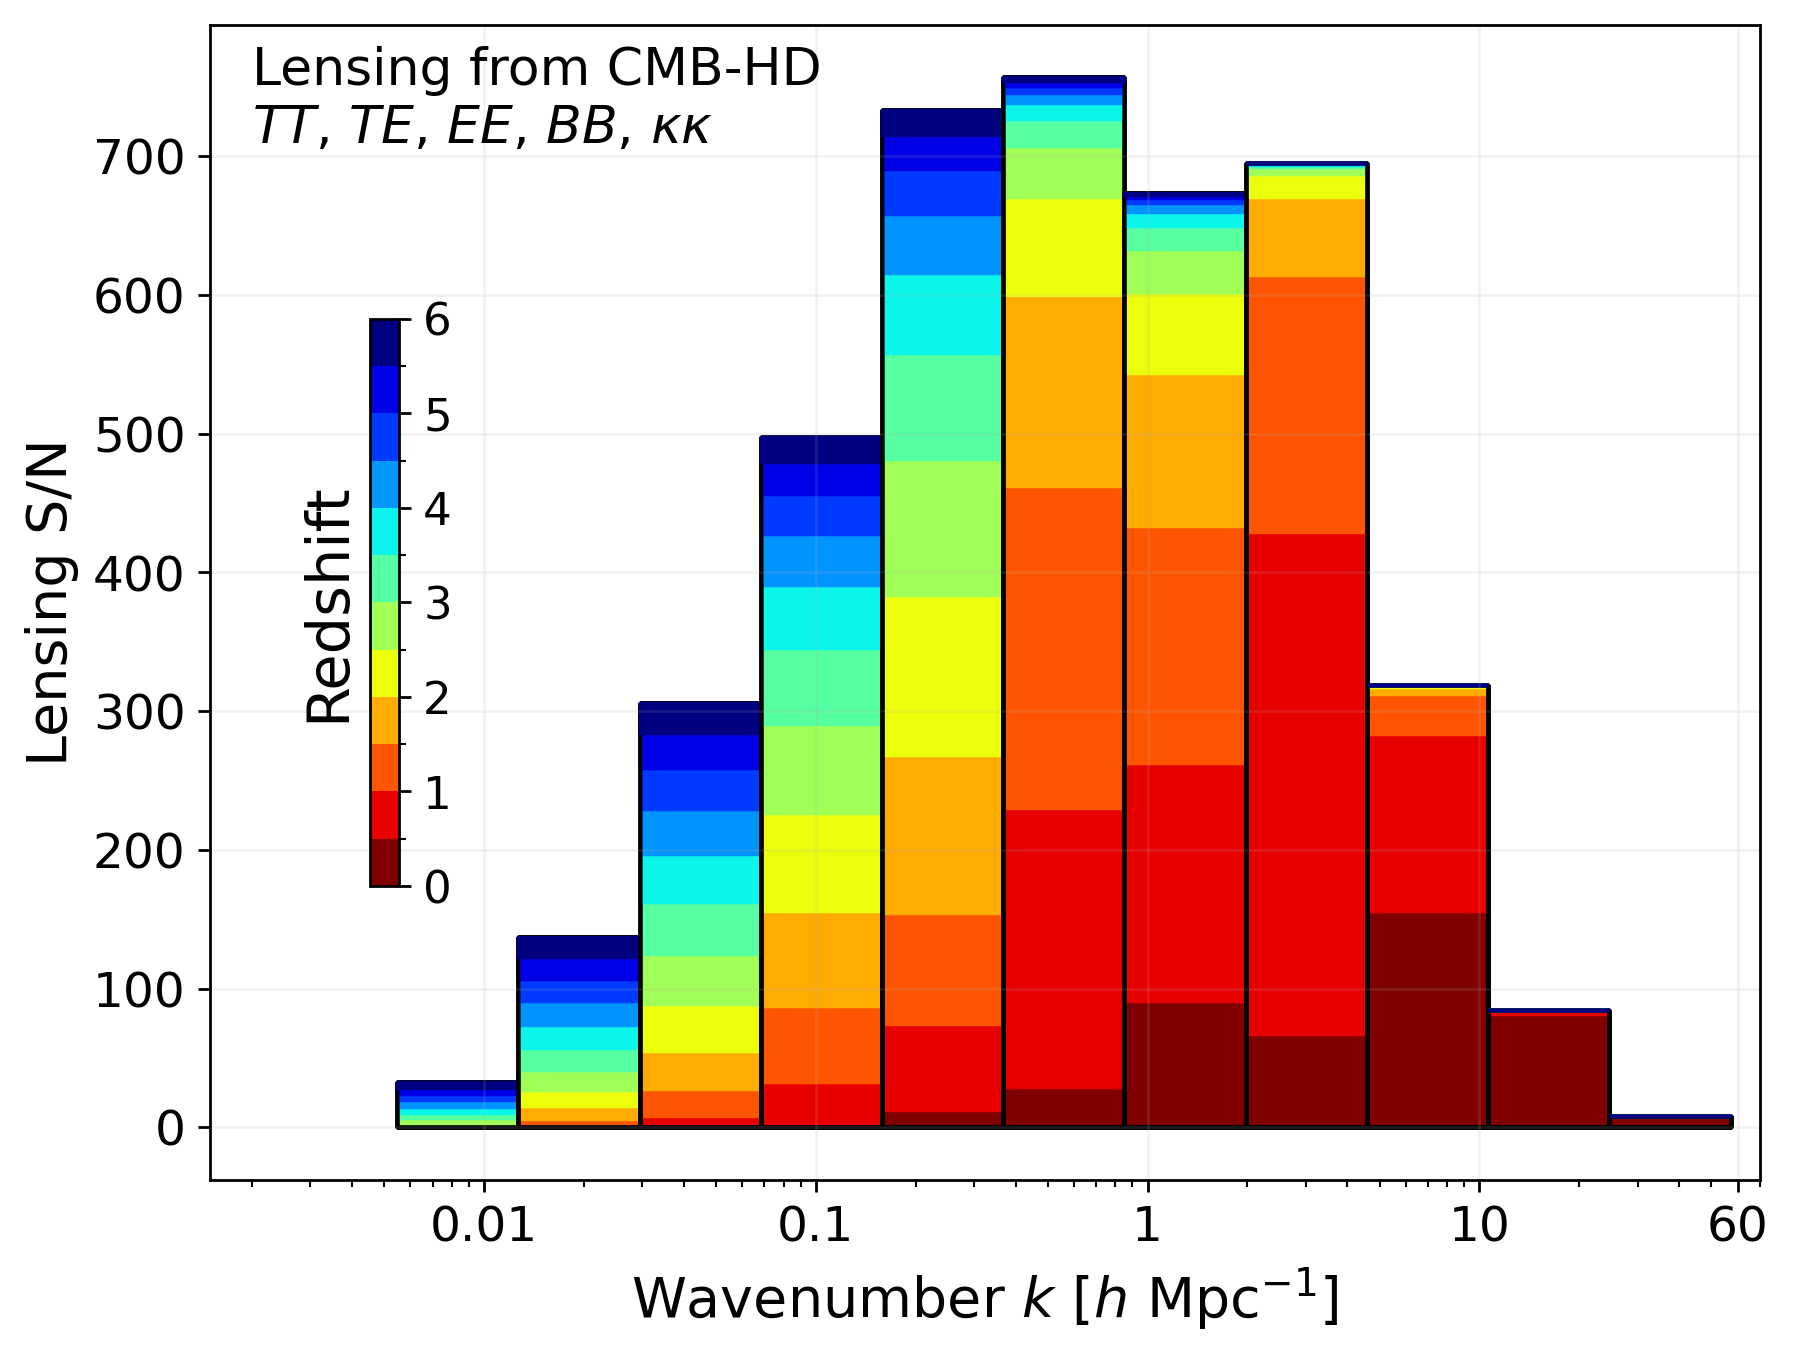

In [36]:
# setup for the plot:
ticksize = 14
xmin = 1e-3 / h
xmax = 70
kticks = [1e-2, 1e-1, 1, 10, 60]
ktick_labels = ['0.01', '0.1', '1', '10', '60']
colors = plt.cm.jet_r(np.linspace(0, 1, z_nbins))

# make the figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.grid(alpha=0.15)
# loop through wavenumber bins and redshift bins to make the histogram:
for j in range(k_nbins):
    kmin_bin = k_bin_edges[j]
    kmax_bin = k_bin_edges[j+1]
    snr_to_zbin = 0
    for i in range(z_nbins):
        tot_snr = snr_per_kbin[j]
        ax.fill_between([kmin_bin/h, kmax_bin/h], [tot_snr, tot_snr], facecolor='none', edgecolor='k')
        if i == 0:
            ymax = snr_per_kbin_zbin_frac[j][i] * tot_snr
            ax.fill_between([kmin_bin/h, kmax_bin/h], [ymax, ymax], color=colors[i])
        else:
            ymin = snr_to_zbin
            ymax = snr_to_zbin + snr_per_kbin_zbin_frac[j][i] * tot_snr
            ax.fill_between([kmin_bin/h, kmax_bin/h], [ymin, ymin], [ymax, ymax], color=colors[i])
        snr_to_zbin += snr_per_kbin_zbin_frac[j][i] * tot_snr

ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.set_xscale('log')
ax.set_xticks(kticks, labels=ktick_labels)
ax.tick_params(axis='x', labelsize=ticksize)
ax.tick_params(axis='y', labelsize=ticksize)
ax.set_xlim([xmin, xmax])
ax.set_xlabel(r'Wavenumber $k~[h~\mathrm{Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel('Lensing S/N', fontsize=16)

# add some text:
font2 = {'color':  'k',
        'weight': 'normal',
        'size': 15,
        }    
txt = 'Lensing from CMB-HD\n'+r'$TT$, $TE$, $EE$, $BB$, $\kappa\kappa$' 
plt.text(2e-3, 710, txt, fontdict=font2)

# make a color bar:
cbar_ax = fig.add_subplot(1, 7, 1)
cmap = plt.get_cmap("jet", z_nbins)
cmaprev=cmap.reversed()
norm= matplotlib.colors.BoundaryNorm(z_bin_edges, z_nbins)
sm = plt.cm.ScalarMappable(cmap=cmaprev, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=cbar_ax, ticks=[int(z) for z in z_bin_edges[0::2]], shrink=2)
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
for spine in ['top', 'bottom', 'left', 'right']:
    cbar_ax.spines[spine].set_visible(False)
cbar.ax.yaxis.set_label_position('left')
cbar_ax.set_facecolor('none')
cbar.set_label(r'Redshift', rotation=90, fontsize=ticksize+3)
cbar.ax.tick_params(labelsize=13) 

if save:
    plt.savefig(os.path.join(output_dir, 'fig06_top_hd.pdf'), dpi=250, bbox_inches='tight')
plt.show()

---

# Calculate and save the CMB-HD data points in Figure 2

In Figure 2 (which is plotted in a separate notebook), we forecast CMB-HD lensing constraints on the _linear_ matter power spectrum today. We place the CMB-HD data points on the theoretical matter power spectrum at the wavenumber ($k$) bin centers, but now use 22 bins. 

We write the SNR values per $k$ bin as $(S/N)_{k_j} = P_\mathrm{non-lin}(k_j) / \sigma\left[P_\mathrm{non-lin}(k_j)\right]$, where $P_\mathrm{non-lin}(k)$ is the _non-linear_ matter power spectrum and $k_j$ is the $j^\mathrm{th}$ wavenumber bin center, then we take our error bar on the _linear_ matter power spectrum $P(k)$ to be $\sigma[P(k_j)] = P(k_j) / (S/N)_{k_j}$.

Below we re-calculate the $(S/N)_{k_j}$ in the same way we did above, but now for 22 bins:

In [37]:
k_nbins_fig2 = 22
k_bin_edges_fig2 = 10**np.linspace(log_kmin, log_kmax, k_nbins_fig2+1)
k_bin_ctrs_fig2 = (k_bin_edges_fig2[1:] + k_bin_edges_fig2[:-1]) / 2

# loop through the wavenumber bins to find the total lensing S/N in each:
snr_per_kbin_fig2 = {} # per k
snr_per_kbin_zbin_fig2 = {} # per k and z
for j in range(k_nbins_fig2):
    kmin_bin = k_bin_edges_fig2[j]
    kmax_bin = k_bin_edges_fig2[j+1]
    snr_per_kbin_zbin_fig2[j] = {}
    for i, z in enumerate(z_bin_ctrs):
        # find minimum and maximum multipoles within this redshift and wavenumber bin:
        lmin_bin = round(kmin_bin * bg_results.comoving_radial_distance(z) - 0.5)
        lmax_bin = round(kmax_bin * bg_results.comoving_radial_distance(z) - 0.5)
        loc = np.where((ells[lmin:lmaxTT+1] >= lmin_bin) & (ells[lmin:lmaxTT+1] <= lmax_bin))[0]
        # sum over them:
        snr_per_kbin_zbin_fig2[j][i] = np.sqrt(np.sum(snr_per_ell_zbin[i][loc]**2))
    # sum over the redshift bins to get the total:
    snr_per_kbin_fig2[j] = np.sqrt(np.sum([snr_per_kbin_zbin_fig2[j][i]**2 for i in range(z_nbins)]))

We plot Figure 2 in a separate notebook by loading in the pre-computed data points and error bars. Here, we load in the pre-computed linear matter power spectrum, evaluated at the $k$ bin centers in units of $(\mathrm{Mpc}/h)^3$, and multiply it by $1/(S/N)_{k_j}$ to save the error bars. We also save the CMB-HD bin centers in units of $h/\mathrm{Mpc}$.

In [38]:
pk_file = os.path.join(cmb_from_pk.hd_pk_dir(), 'pk_plot_data/hd_Pks.txt')
pk_lin_binned = np.loadtxt(pk_file)
hd_pk_lin_errors = np.array([pk_lin_binned[j] / snr_per_kbin_fig2[j] for j in range(k_nbins_fig2)])

if save:
    np.savetxt(os.path.join(output_dir, 'fig02_hd_pk_data.txt'),
              np.column_stack([k_bin_ctrs_fig2/h, pk_lin_binned, hd_pk_lin_errors]),
              header='k [h/Mpc], P_lin(k) [(Mpc/h)^2], error on P_lin(k) [(Mpc/h)^2]')